<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization - CS 155 Project 2

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")

# Split the MovieLens dataset into a training set (of size 109,351) and a test set (of size 12,150)
split_ratio = 0.099999 # 0.1 misses the 109,351:12,150 split by 1 datapoint

train_df, test_df = train_test_split(data, test_size=split_ratio) # takes care of shuffling
train_data = train_df.to_numpy().astype('int64')
test_data = test_df.to_numpy().astype('int64')

M_users = data.iloc[:,0].max() + 1
N_movies = len(movies) 
R_ratings = len(data)

print("Number of Users (M):", M_users)
print("Number of Movies (N):", N_movies)
print("Number of Ratings (Data):", R_ratings)
print("Size of Training Dataset:", len(train_data))
print("Size of Test Dataset:", len(test_data))

Number of Users (M): 992
Number of Movies (N): 1500
Number of Ratings (Data): 121501
Size of Training Dataset: 109351
Size of Test Dataset: 12150


# Matrix Factorization Visualization

##Visualization Helper Methods

In [ ]:
def plot_reg_eta_comparison(regs, etas, errors, title, is_error_out=True):
  """
  Plots, shows, and saves the graph of error given different 
  learning rates and regularization.
  """
  label_header = "$E_{out}, λ=$"
  if not is_error_out:
    label_header = '$E_{in}, λ=$'

  for i in range(len(regs)):
    plt.plot(etas, errors[i], label=label_header + str(regs[i]))
  plt.title(title)
  plt.ylabel('Error')
  plt.xlabel('Learning Rate (eta)')
  plt.legend()
  plt.savefig(title)	
  plt.show()

In [ ]:
def visualize(ids, title, V_tilda):
    plt.figure(figsize=(10,10))
    plt.scatter(V_tilda[0][ids], V_tilda[1][ids], s=num_ratings[ids] * 10, c=avg_ratings[ids], cmap=plt.get_cmap('RdYlGn'), alpha=0.6)
    plt.colorbar().set_label("Average rating")
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    for id, movie_title in movies[['Movie ID', 'Movie Title']].values[ids]:
        x, y = V_tilda[0][id], V_tilda[1][id]
        plt.annotate(movie_title, xy=(x, y), horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=0, arrowprops=dict(arrowstyle='-', lw=1, alpha=0.6))
    plt.savefig(title)
    plt.show()

In [ ]:
def create_visualizations(U, V, method_num):
    N = len(V)
    A = np.linalg.svd(V.transpose())[0]
    V_tilda = np.dot(A[:, :2].transpose(), V.transpose())
    U_tilda = np.dot(A[:, :2].transpose(), U.transpose())

    # find total ratings, number of ratings, and average ratings for each movie
    tot_ratings = np.zeros(N)
    num_ratings = np.zeros(N)

    for index, row in data.iterrows():
        movie_id = row['Movie ID']
        rating = row['Rating']

        num_ratings[int(movie_id)] += 1
        tot_ratings[int(movie_id)] += rating

    avg_ratings = np.array([tot_ratings[i]/num_ratings[i] for i in range(N)])

    # ten movies of our choice
    choice_movies = [15, 106, 335, 445, 530, 554, 608, 773, 924, 1058]

    # ten most popular movies
    pop_ids = np.argsort(num_ratings)[-10:]

    # ten best movies
    best_ids = np.argsort(avg_ratings)[-10:]

    # movies by genre
    comedy_movies = movies[['Movie ID', 'Movie Title', 'Comedy']]
    comedy_ids = comedy_movies[comedy_movies['Comedy'] == 1][:10]['Movie ID']

    horror_movies = movies[['Movie ID', 'Movie Title', 'Horror']]
    horror_ids = horror_movies[horror_movies['Horror'] == 1][:10]['Movie ID']

    scifi_movies = movies[['Movie ID', 'Movie Title', 'Sci-Fi']]
    scifi_ids = scifi_movies[scifi_movies['Sci-Fi'] == 1][:10]['Movie ID']

    # Creates visualizations
    visualize(choice_movies, '2D Visualization of 10 Movies of our Choice: Method ' + str(method_num), V_tilda)
    visualize(best_ids, '2D Visualization of 10 Best Movies: Method ' + str(method_num), V_tilda)
    visualize(pop_ids, '2D Visualization of 10 Popular Movies: Method ' + str(method_num), V_tilda)
    visualize(comedy_ids, '2D Visualization of 10 Comedy Movies: Method ' + str(method_num), V_tilda)
    visualize(horror_ids, '2D Visualization of 10 Horror Movies: Method ' + str(method_num), V_tilda)
    visualize(scifi_ids, '2D Visualization of 10 Sci-Fi Movies: Method ' + str(method_num), V_tilda)

##Method 1

In [ ]:
from numpy.core.numeric import True_
from operator import truediv

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.inner(Ui, Vj)))   

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.inner(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    error = 0.5 * reg * (np.linalg.norm(U,ord='fro') ** 2 + np.linalg.norm(V,ord='fro') ** 2)
    for i, j, Yij in Y:
        error += 0.5 * (Yij - np.inner(U[i-1],V[j-1])) ** 2

    return error / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M,K))
    V = np.random.uniform(-0.5, 0.5, (N,K))

    err_prev = get_err(U, V, Y, reg=reg)
    initial_err_reduction = 0

    for k in range(max_epochs):
        shuffled_ids = np.random.permutation(len(Y))
        for idx in shuffled_ids:
            i, j, Yij = Y[idx]
            i -= 1
            j -= 1

            U[i] = U[i] - grad_U(U[i], Yij, V[j], reg, eta)
            V[j] = V[j] - grad_V(V[j], Yij, U[i], reg, eta)
        
        err_curr = get_err(U, V, Y, reg=reg)

        if k == 0:
           initial_err_reduction = err_prev - err_curr
        elif (err_prev - err_curr) / initial_err_reduction < eps:
            print ("Took", k + 1, "Epochs.")
            break
        elif k == max_epochs - 1:
            print ("Took Maximum of", k + 1, "Epochs.")

        err_prev = err_curr

    return (U, V, get_err(U, V, Y))

Method 1
Factorizing with  992  users,  1500  movies.
Latent Factor Dimensionality of K = 20
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.0001
Took 57 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.02, reg = 0.0001
Took 28 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.03, reg = 0.0001
Took 17 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.04, reg = 0.0001
Took 9 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.05, reg = 0.0001
Took 6 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.06, reg = 0.0001
Took 15 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.07, reg = 0.0001
Took 20 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.08, reg = 0.0001
Took 24 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.09, reg = 0.0001
Took 33 Epochs.
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.001
Took 47 Epochs.
Training model with M = 992, N

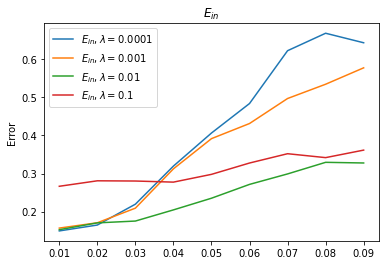

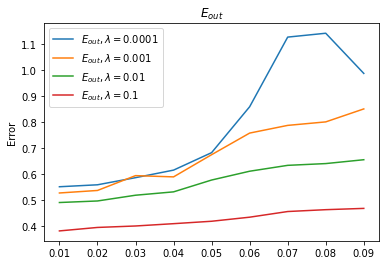

In [ ]:
# M and N defined above
K = 20
print("Method 1")
print("Factorizing with ", M_users, " users, ", N_movies, " movies.")
print("Latent Factor Dimensionality of K =", K)

regs = [10**-4, 10**-3, 10**-2, 10**-1]
etas = [10**-2,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for eta in etas:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M_users, N_movies, K, eta, reg))
        U, V, e_in = train_model(M_users, N_movies, K, eta, reg, train_data)
        E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, test_data)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)

Plots the Error Graphs for Method 1

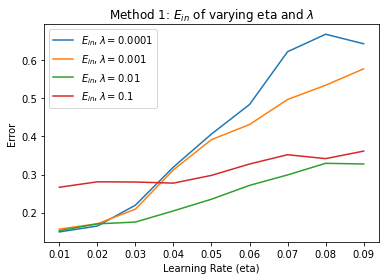

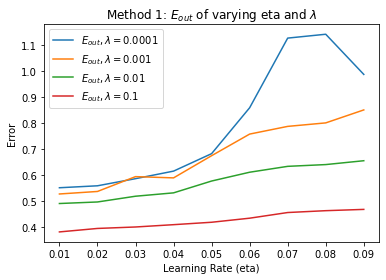

In [ ]:
plot_reg_eta_comparison(regs, etas, E_ins, "Method 1: $E_{in}$ of varying eta and $\lambda$", False)
plot_reg_eta_comparison(regs, etas, E_outs, "Method 1: $E_{out}$ of varying eta and $\lambda$")

From this, we see that the eta of 0.01 and reg of 0.1 give us the lowest test error.

Thus, we'll do the Method 1 Visualizations for our model with an eta of 0.01 and reg of 0.1.

In [ ]:
# Trains Method 1 Best Model using eta and reg values that give us the lowest test error
K = 20
eta = 0.01
reg = 0.1

U, V, ein = train_model(M_users, N_movies, K, eta, reg, train_data)
eout = get_err(U, V, test_data)
print("Error in:", ein)
print("Error out:", eout)

Took 30 Epochs.
Error in: 0.2755295338285619
Error out: 0.38821803134379446


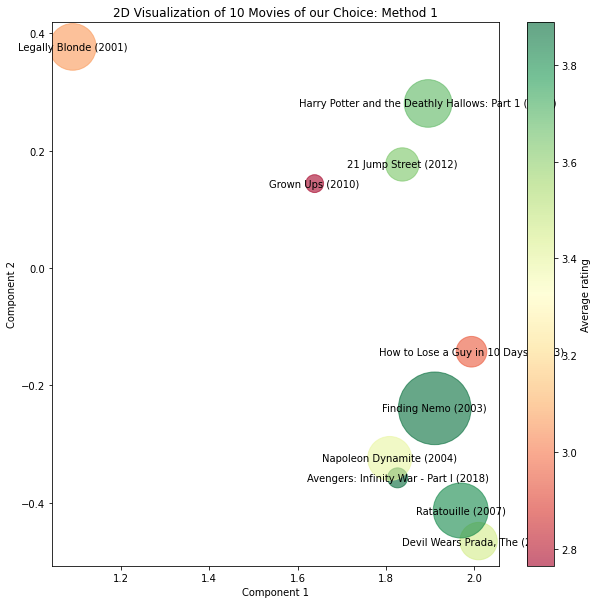

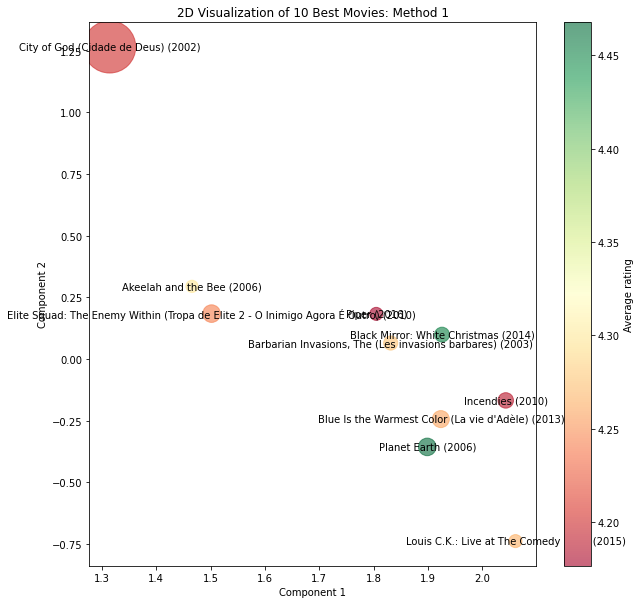

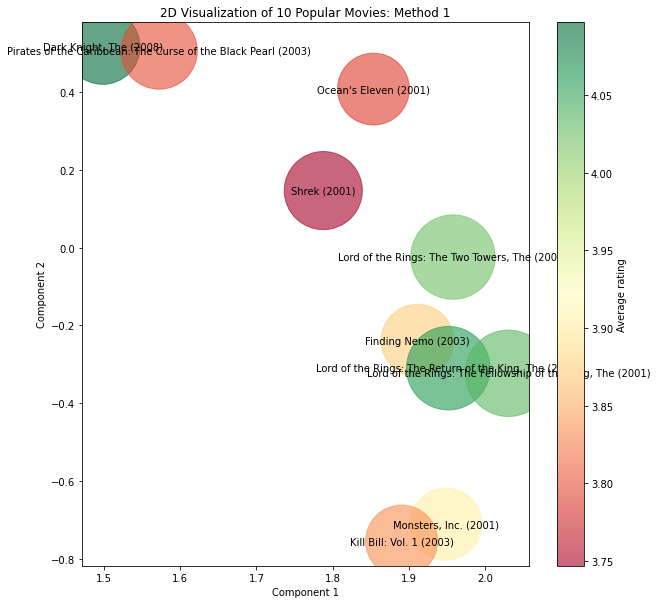

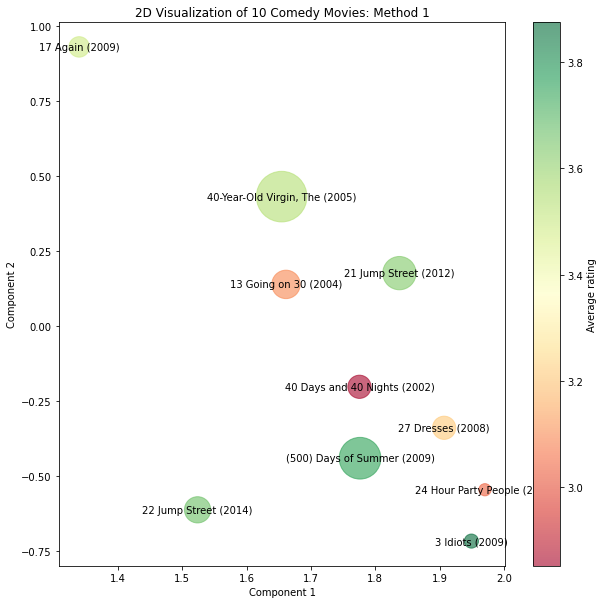

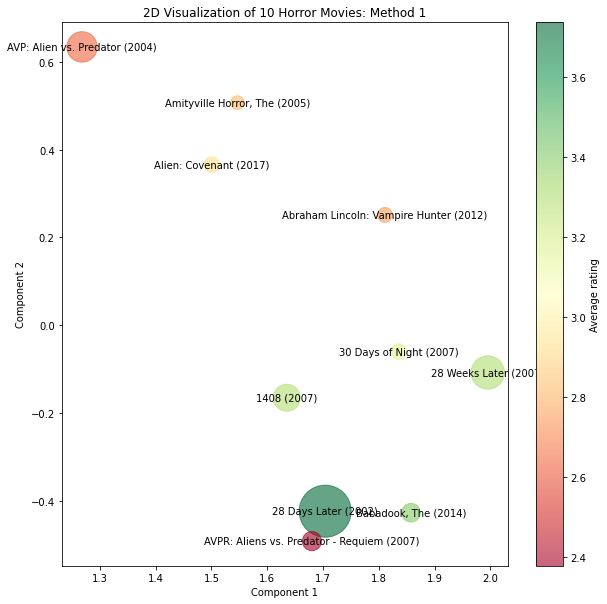

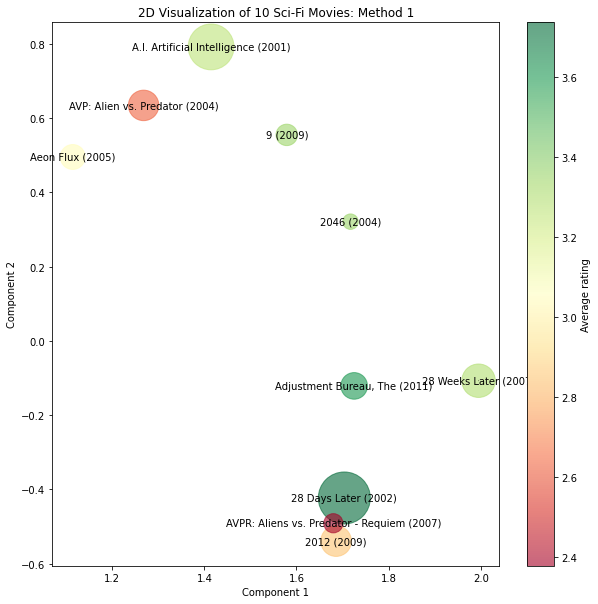

In [ ]:
# Method 1 Visualizations
create_visualizations(U, V, 1)

##Method 2

The following method trains the model including global bias tendency vectors a and b. 

In [ ]:
def get_err_with_bias(U, V, a, b, mean, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and the
    model represented by user/movie matrices U and V and user/movie bias terms a and b.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T
    plus the ith element of user vector a and the jth element of movie vector b.
    """
    error = 0.5 * reg * (np.linalg.norm(U,ord='fro') ** 2 + np.linalg.norm(V,ord='fro') ** 2 + a.dot(a) + b.dot(b))
    for i, j, Yij in Y:
        error += 0.5 * ( (Yij - mean) - ( (U[i-1]).dot(V[j-1]) + a[i-1] + b[j-1])) ** 2

    return error / (1.0 * len(Y))

def train_model_with_bias(M, N, K, eta, reg, Y, printErrors=False, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U, N x K matrix V, gloal user bias M-vector, and 
    global movie bias N-vector such that rating Y_ij is approximated
    by (UV^T)_ij + a_i + b_j.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, a, b, mean, err) consisting of model defining parameters 
    U, V, a, b, the mean of the labels used in training and the unregularized MSE.
    """
    # Initializes our model: U, V, a, b
    U = np.random.uniform(-0.5, 0.5, (M,K))
    V = np.random.uniform(-0.5, 0.5, (N,K))
    a = np.random.uniform(-0.5, 0.5, (M, ))
    b = np.random.uniform(-0.5, 0.5, (N, ))

    # Stores mean of labels
    mean_Y = np.mean(Y[:, 2])

    err_prev = get_err_with_bias(U, V, a, b, mean_Y, Y, reg=reg)
    initial_err_reduction = 0

    for k in range(max_epochs):
        shuffled_ids = np.random.permutation(len(Y))
        for idx in shuffled_ids:
            i, j, Yij = Y[idx]

            intermediate = (Yij - mean_Y) - ( (U[i-1]).dot(V[j-1]) + a[i-1] + b[j-1])
            U[i-1] = U[i-1] - eta * (reg * U[i-1] - V[j-1] * intermediate)
            V[j-1] = V[j-1] - eta * (reg * V[j-1] - U[i-1] * intermediate)
            a[i-1] = a[i-1] - eta * (reg * a[i-1] - intermediate)
            b[j-1] = b[j-1] - eta * (reg * b[j-1] - intermediate)
  
        err_curr = get_err_with_bias(U, V, a, b, mean_Y, Y, reg=reg)

        if k == 0:
           initial_err_reduction = err_prev - err_curr
        elif (err_prev - err_curr) / initial_err_reduction <= eps:
            print ("Took", k + 1, "Epochs.")
            break
        elif k == max_epochs - 1:
            print ("Took Maximum of", k + 1, "Epochs.")
        
        if printErrors:
            print ("Epoch", k + 1, ": Training Error of", err_curr)

        err_prev = err_curr

    return (U, V, a, b, mean_Y, get_err_with_bias(U, V, a, b, mean_Y, Y))

Since method 1 and method 2 are very similar, we thought that the optimal parameters for method 2 would be close to the optimal parameters for method 1.
Thus, we tested method 2 with learning step sizes and regularizations parameters that were very close to the ones from method 1. By honing in on these predicted optima, we were able to limit our testing and avoid uselessly training models we knew would perform poorly.

Ultimately, our intuition was confirmed as method 1 and method 2 proved to share the same optimal parameters for eta and reg.

In [ ]:
import warnings
warnings.filterwarnings('error')
np.seterr(all='warn')

# M and N defined above
K = 20
print("Method 2")
print("Factorizing with ", M_users, " users, ", N_movies, " movies.")
print("Latent Factor Dimensionality of K =", K)

regs = [0.001, 0.01, 0.1, 0.2]
etas = [0.01,0.02,0.03]
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for eta in etas:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M_users, N_movies, K, eta, reg))

        U, V, a, b, mean, e_in = (None, None, None, None, None, None)
        try:
          U, V, a, b, mean, e_in = train_model_with_bias(M_users, N_movies, K, eta, reg, train_data)
        except Warning:
          print('Overflow Encountered in Training; Aborting Model.')
          E_ins_for_lambda.append(-1)
          E_outs_for_lambda.append(-1)
          continue

        E_ins_for_lambda.append(e_in)
        eout = get_err_with_bias(U, V, a, b, mean, test_data)
        print("Model trained successfully!\n\tError in:", e_in, "\tError out:", eout)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)

Method 2
Factorizing with  992  users,  1500  movies.
Latent Factor Dimensionality of K = 20
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.001
Took 129 Epochs.
Model trained successfully!
	Error in: 0.12125368525431572 	Error out: 0.649397139262377
Training model with M = 992, N = 1500, k = 20, eta = 0.02, reg = 0.001
Took 48 Epochs.
Model trained successfully!
	Error in: 0.13529146716529072 	Error out: 0.6368252320624921
Training model with M = 992, N = 1500, k = 20, eta = 0.03, reg = 0.001
Took 18 Epochs.
Model trained successfully!
	Error in: 0.16567523783652865 	Error out: 0.5675018830649743
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.01
Took 159 Epochs.
Model trained successfully!
	Error in: 0.12057754825891763 	Error out: 0.5620400074299791
Training model with M = 992, N = 1500, k = 20, eta = 0.02, reg = 0.01
Took 57 Epochs.
Model trained successfully!
	Error in: 0.12905091334865645 	Error out: 0.5502092099293788
Training model with M =

Plots the Error Graphs for Method 2

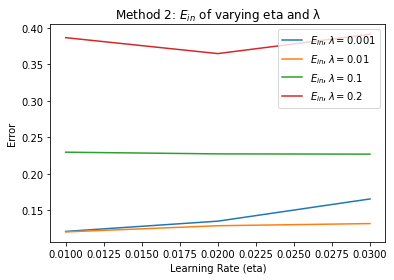

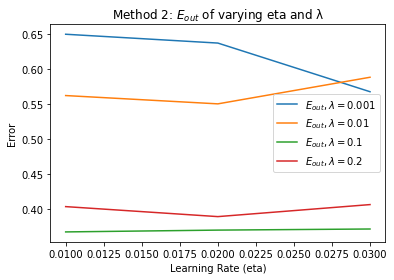

In [ ]:
plot_reg_eta_comparison(regs, etas, E_ins, "Method 2: $E_{in}$ of varying eta and λ", False)
plot_reg_eta_comparison(regs, etas, E_outs, "Method 2: $E_{out}$ of varying eta and λ")

In [ ]:
# Trains Method 2 Best Model using eta and reg values that give us the lowest test error
K = 20
eta = 0.01
reg = 0.1

U, V, a, b, mean, ein = train_model_with_bias(M_users, N_movies, K, eta, reg, train_data, printErrors=True)
eout = get_err_with_bias(U, V, a, b, mean, test_data)

print()
print("Error in:", ein)
print("Error out:", eout)

Epoch 1 : Training Error of 0.4480839814402173
Epoch 2 : Training Error of 0.4044702463105754
Epoch 3 : Training Error of 0.38696679429223924
Epoch 4 : Training Error of 0.3776375811981828
Epoch 5 : Training Error of 0.3713716569822987
Epoch 6 : Training Error of 0.3665280749416365
Epoch 7 : Training Error of 0.3624880667636333
Epoch 8 : Training Error of 0.358465569533525
Epoch 9 : Training Error of 0.35407060545872654
Epoch 10 : Training Error of 0.34974187882035357
Epoch 11 : Training Error of 0.34516022657281964
Epoch 12 : Training Error of 0.3402530008655917
Epoch 13 : Training Error of 0.33549719831525804
Epoch 14 : Training Error of 0.33072852916608364
Epoch 15 : Training Error of 0.32581616147068615
Epoch 16 : Training Error of 0.32116762754151157
Epoch 17 : Training Error of 0.31672644579164877
Epoch 18 : Training Error of 0.31242294763041867
Epoch 19 : Training Error of 0.3086427028781035
Epoch 20 : Training Error of 0.3047705377616189
Epoch 21 : Training Error of 0.301128248

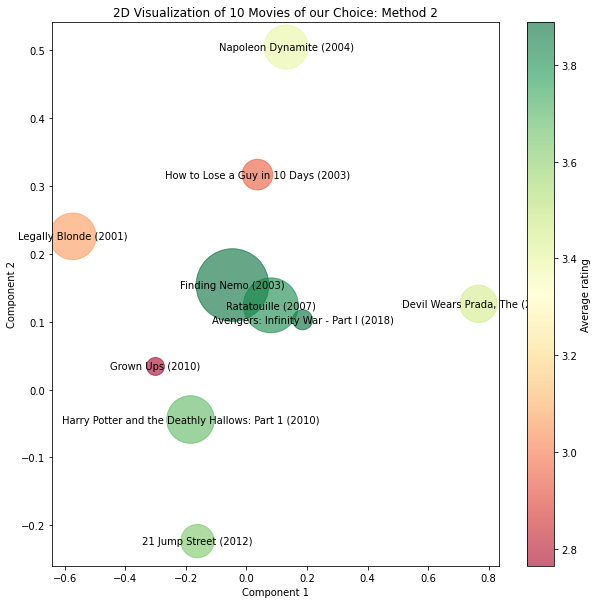

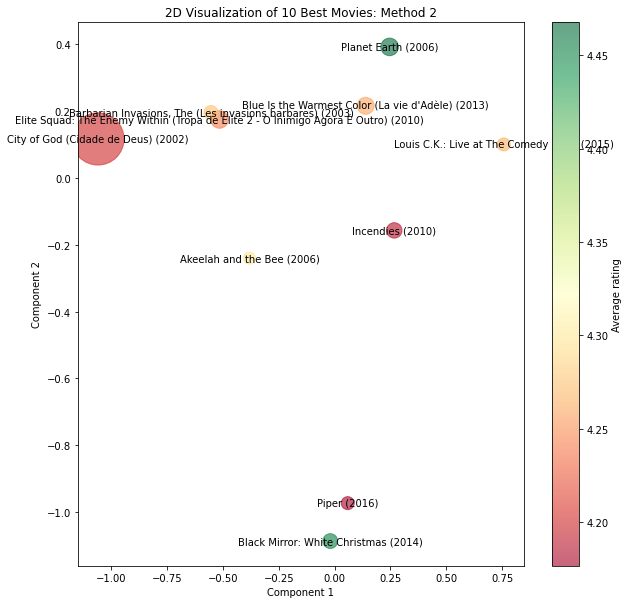

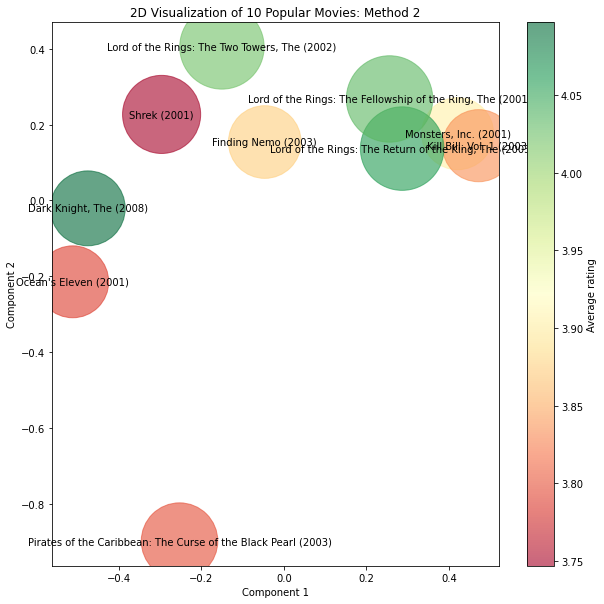

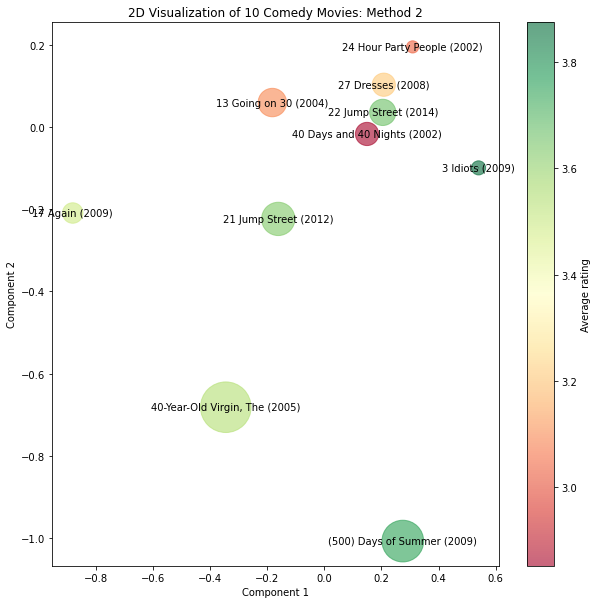

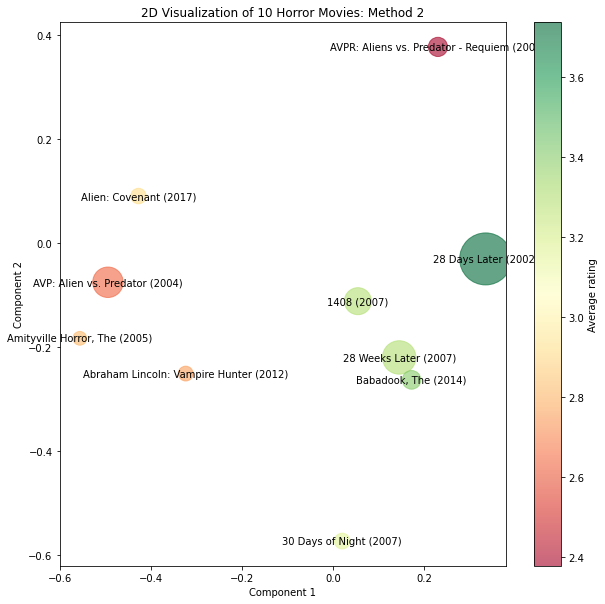

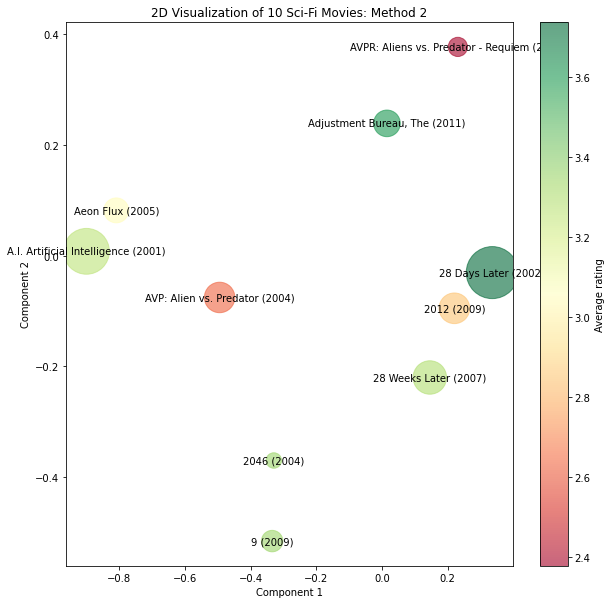

In [ ]:
# Method 2 Visualizations
create_visualizations(U, V, 2)

##Method 3

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366561 sha256=193610c7938813e2d077a06676e2fc06d85cc019b51769d8e902ab43726ac39f
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise import accuracy

def surprise_SVD(train_df, test_df):
  reader = Reader()

  train = Dataset.load_from_df(train_df, reader).build_full_trainset()
  test = Dataset.load_from_df(test_df, reader).build_full_trainset().all_ratings()

  algo = SVD()
  algo.fit(train)
  preds = algo.test(test)

  test_err = accuracy.mse(preds)

  U = algo.pu.T
  V = algo.qi.T
  A, sigma, B = np.linalg.svd(V)
  return (U, V, np.matmul(A[:,:2].T, U), np.matmul(A[:,:2].T, V), test_err)

In [ ]:
U_3, V_3, U_tilde_3, V_tilde_3, test_err_3 = surprise_SVD(train_df, test_df)

MSE: 1.4381


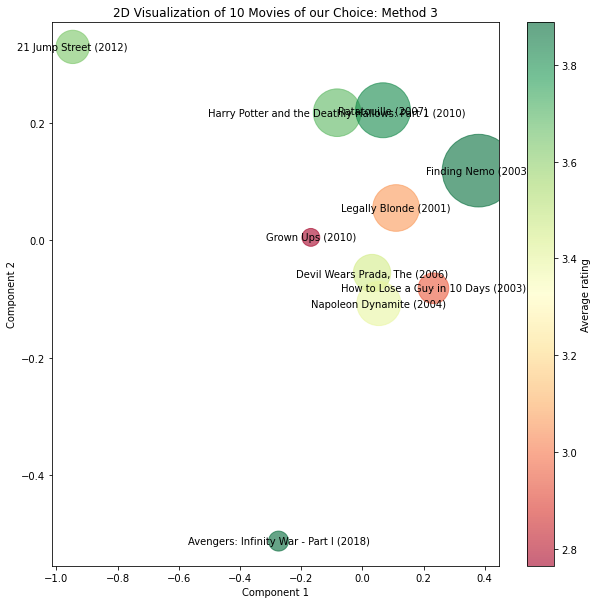

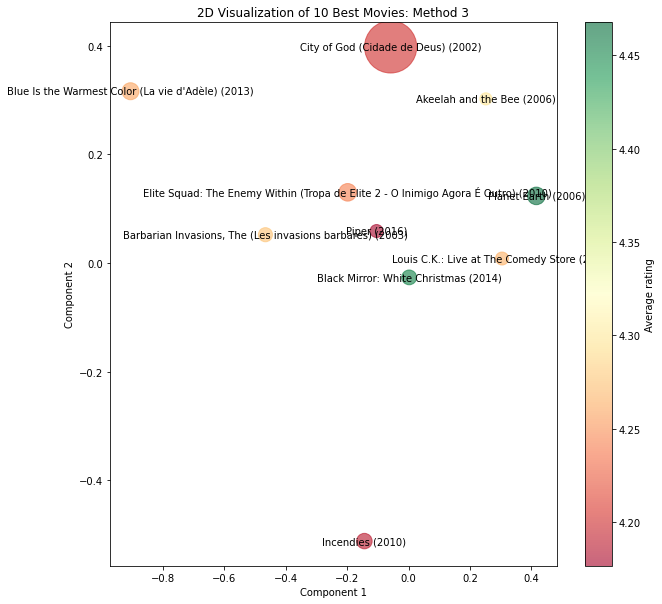

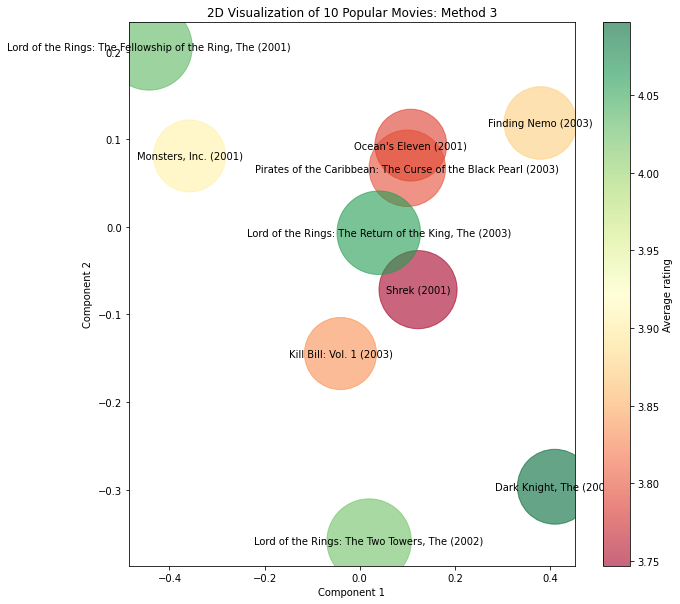

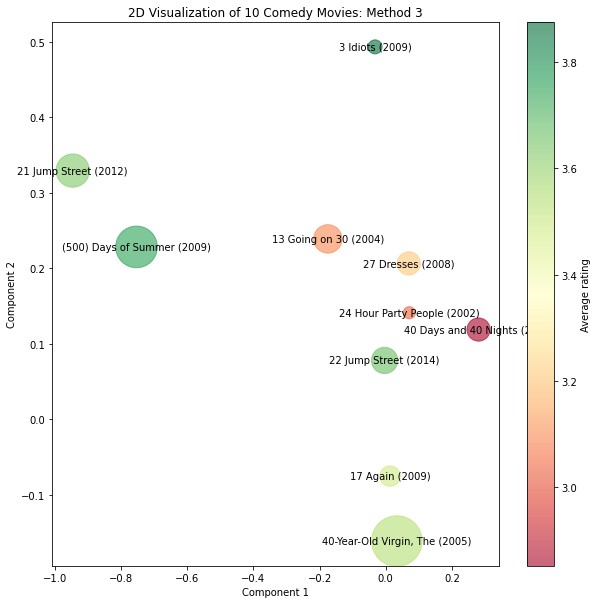

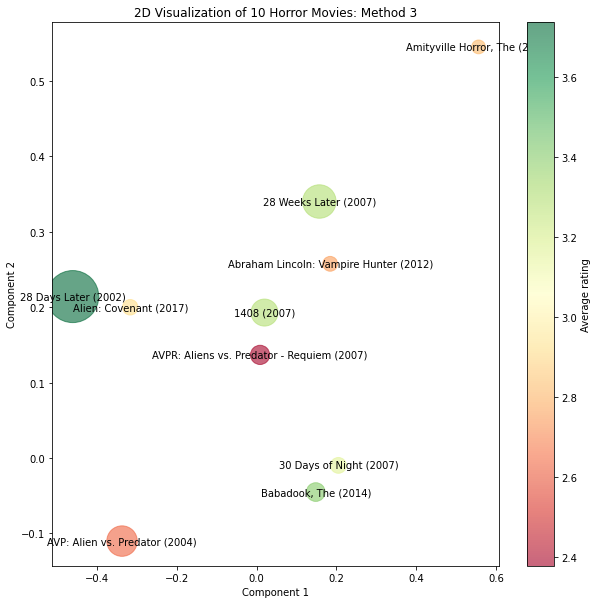

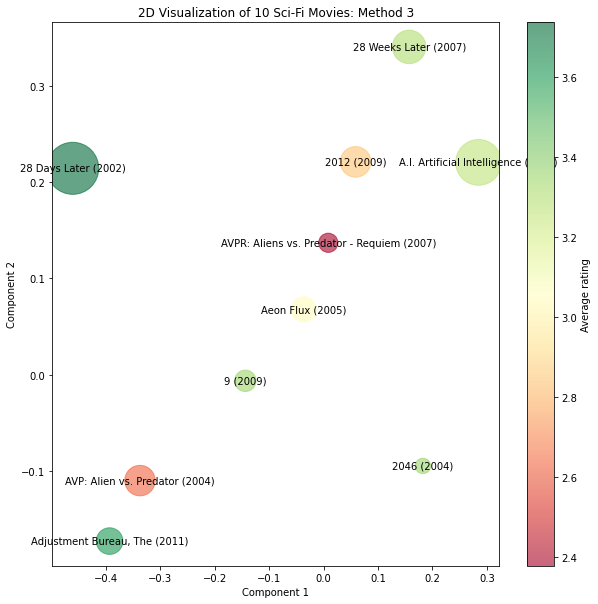

In [ ]:
N = N_movies

# find total ratings, number of ratings, and average ratings for each movie
tot_ratings = np.zeros(N)
num_ratings = np.zeros(N)

for index, row in data.iterrows():
    movie_id = row['Movie ID']
    rating = row['Rating']

    num_ratings[int(movie_id)] += 1
    tot_ratings[int(movie_id)] += rating

avg_ratings = np.array([tot_ratings[i]/num_ratings[i] for i in range(N)])

# ten movies of our choice
choice_movies = [15, 106, 335, 445, 530, 554, 608, 773, 924, 1058]

# ten most popular movies
pop_ids = np.argsort(num_ratings)[-10:]

# ten best movies
best_ids = np.argsort(avg_ratings)[-10:]

# movies by genre
comedy_movies = movies[['Movie ID', 'Movie Title', 'Comedy']]
comedy_ids = comedy_movies[comedy_movies['Comedy'] == 1][:10]['Movie ID']

horror_movies = movies[['Movie ID', 'Movie Title', 'Horror']]
horror_ids = horror_movies[horror_movies['Horror'] == 1][:10]['Movie ID']

scifi_movies = movies[['Movie ID', 'Movie Title', 'Sci-Fi']]
scifi_ids = scifi_movies[scifi_movies['Sci-Fi'] == 1][:10]['Movie ID']

# Create visualizations
visualize(choice_movies, '2D Visualization of 10 Movies of our Choice: Method 3', V_tilde_3)
visualize(best_ids, '2D Visualization of 10 Best Movies: Method 3', V_tilde_3)
visualize(pop_ids, '2D Visualization of 10 Popular Movies: Method 3', V_tilde_3)
visualize(comedy_ids, '2D Visualization of 10 Comedy Movies: Method 3', V_tilde_3)
visualize(horror_ids, '2D Visualization of 10 Horror Movies: Method 3', V_tilde_3)
visualize(scifi_ids, '2D Visualization of 10 Sci-Fi Movies: Method 3', V_tilde_3)

# Method Comparisons

Here, we take the best models trained from every method and compare their test errors using MSE on the models' predictions versus the ratings.

In [ ]:
print("Number of Users (M):", M_users)
print("Number of Movies (N):", N_movies)
print("Number of Ratings (Data):", R_ratings)
print("Size of Training Dataset:", len(train_data))
print("Size of Test Dataset:", len(test_data))

Number of Users (M): 992
Number of Movies (N): 1500
Number of Ratings (Data): 121501
Size of Training Dataset: 109351
Size of Test Dataset: 12150


In [ ]:
# METHOD 1 BEST MODEL
# Train Model
print("Training with Method 1")
K = 20
eta = 0.01
reg = 0.1

U1, V1, ein1 = train_model(M_users, N_movies, K, eta, reg, train_data)
eout1 = get_err(U1, V1, test_data)


# Compute MSE
MSE1 = 0
for i, j, rating in test_data:
  prediction = (U1[i-1]).dot(V1[j-1])
  error = rating - prediction
  MSE1 += error ** 2
MSE1 /= len(test_data)
print("Method 1 Best Model MSE:", MSE1)
print()




# METHOD 2 BEST MODEL
# Train Model
print("Training with Method 2")
K = 20
eta = 0.01
reg = 0.1

U2, V2, a2, b2, mean2, ein2 = train_model_with_bias(M_users, N_movies, K, eta, reg, train_data)
eout2 = get_err_with_bias(U2, V2, a2, b2, mean2, test_data)


# Compute MSE
MSE2 = 0
for i, j, rating in test_data:
  prediction =  mean2 + (U2[i-1]).dot(V2[j-1]) + a2[i-1] + b2[j-1]
  error = rating - prediction
  MSE2 += error ** 2
MSE2 /= len(test_data)
print("Method 2 Best Model MSE:", MSE2)
print()



# METHOD 3 BEST MODEL

# Train Model
print("Training with Method 3")
reader = Reader()
training_set = Dataset.load_from_df(train_df, reader).build_full_trainset()
test_set = Dataset.load_from_df(test_df, reader).build_full_trainset().all_ratings()

algo = SVD()
algo.fit(training_set)
predictions = algo.test(test_set)


# Compute MSE
MSE3 = accuracy.mse(predictions)
print("Method 3 Best Model MSE:", MSE3)

Training with Method 1
Took 31 Epochs.
Method 1 Best Model MSE: 0.7557103461841488

Training with Method 2
Took 85 Epochs.
Method 2 Best Model MSE: 0.7288115039304495

Training with Method 3
MSE: 1.4691
Method 3 Best Model MSE: 1.4691366969955684


## Conclusion

From the comparisons, we conclude that method 2 has the best performance when training models for collaborative filtering. We see above that its best model outputted the smallest mean squared error on the test data compared to the best models of the other 2 methods.